In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
import sys
import analysisE2 as e2

sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec
sys.path.insert(0,'../environments/'); import gw; import gp

import experiment as expt

In [8]:
fields = [
    'save_id',          #uuid
    'experiment_type',  #int
    'load_from',        #str
    'num_trials',       #int
    'num_events',       #int
    'ENVIRONMENT',      #str
    'shape',            #tuple
    'rho',              #float
    'rewards',          #dict
    'action_list',      #list
    'rwd_action',       #str
    'step_penalization',#float
    'useable',          #list
    'obstacle2D',       #list
    'terminal2D',       #list
    'jump',             #list or NoneType
    'random_start',     #bool
    'AGENT',            #arch
    'use_SR',           #bool
    'freeze_weights',   #bool
    'layers',           #list
    'hidden_types',     #list
    'gamma',            #float
    'eta',              #float
    'optimizer',        #torch optim. class
    'MEMORY', #         # string*
    'cache_limit',      #int
    'use_pvals',        #bool
    'memory_envelope',  #int
    'mem_temp',         #float
    'alpha',            #float   # memory mixing parameters
    'beta'              #int
    ]

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def smoothed_reward(data, smoothing):
    smoothed_reward = []
    for x in data:
        if x is None:
            smoothed_reward.append(None)
        else: 
            smoothed_reward.append(running_mean(x.reward_avg, smoothing))
    
    return smoothed_reward
   
def ec_recall(EC, key):
    # cos sim
    key_array = np.asarray(list(EC.keys()))
    entry = np.asarray(key)
    mqt = np.dot(key_array,entry)
    norm = np.linalg.norm(key_array, axis =1) * np.linalg.norm(entry)
    cos_sim = mqt/norm
    lin_act = tuple(key_array[np.argmax(cos_sim)])
    maxcos_sim = max(cos_sim)
    
    # recall
    memory = np.nan_to_num(EC[lin_act][0])
    deltas = memory[:,0]
    policy = ac.softmax(maxcos_sim * deltas, T=0.05)
    return policy
    
    
def ec_policies(maze, EC, trial_timestamp,**kwargs):
    envelope = kwargs.get('decay', 50)
    mem_temp = kwargs.get('mem_temp', 1)
    mpol_array = np.zeros(maze.grid.shape, dtype=[(x, 'f8') for x in maze.action_list])
    
    
    # cycle through readable states
    for key in EC.keys():
        row, col = EC[key][2]
        pol = ec_recall(EC, key)
        mpol_array[row,col] = tuple(pol)
        
    return mpol_array

def plot_from_id(run_id, mf=False):
    if mf:
        agent_dir = f'../data/outputs/gridworld/weights/{run_id}.pt'
        agent = torch.load(agent_dir)
    mem_dir = f'../data/outputs/gridworld/episodic_cache/{run_id}_EC.p'
    mem = pickle.load(open(mem_dir, 'rb'))

    ## to do: build grid from csv specs similar to rwd_loc

    rwd_loc = df.loc[df['Run_ID'] == run_id, 'Rewards'].item()
    r_x = int(rwd_loc[rwd_loc.index('(')+1 : rwd_loc.index(',')])
    r_y = int(rwd_loc[rwd_loc.index(',')+2 : rwd_loc.index(')')])

    reward_location = (r_x,r_y)

    openfield = gw.GridWorld(rows=20, cols=20, env_type=None, rewards={reward_location:1}, step_penalization=-0.01,
                            actionlist=['Down','Up','Right','Left'], rewarded_action=None)
    
    if mf:
        obs = openfield.get_sample_obs()
        mf_pol, mf_val = expt.get_snapshot(obs, openfield, agent)
        gp.plot_pref_pol(openfield,mf_pol, threshold=0.1)


    abcd = ec_policies(openfield,mem,trial_timestamp = 0, mem_temp = 0.5)
    gp.plot_pref_pol(openfield, abcd, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)
    
    
def turds(x, alpha, beta):
    #alpha = bump size
    # beta = number of steps to decay to 0.01
    threshold = 0.01
    decay = np.power(threshold,1/beta)
    a = np.empty_like(x, dtype=float)
    
    for ind, i in enumerate(x):
        if ind == 0:
            a[ind] = i*alpha
        else:
            calc = decay*a[ind-1] + i*alpha
            if calc > 1:
                calc = 1
            a[ind] = calc
    return a

# Load Data Log

In [11]:
# gather all data 
parent_dir = '../data/outputs/gridworld/E2/'
df = pd.read_csv(parent_dir + 'experiments_log.csv')
experiment_types = ['Training', 
                    'MF Only', 
                    'EC ($\psi$)', 
                    'EC ($\phi$)', 
                    'MF Only (free)', 
                    'EC ($\psi$)(free)', 
                    'EC ($\phi$)(free)' ]

## Compare Architecture A (no SR) with Architecture B (using SR)
Testing phase done with either MF alone or EC alone 

[0 5 2] [0]
['None' 'room'] ['None' 'room']
['(20, 20)'] ['(20, 20)']
[0.  0.1] [0.  0.1]
["['Down', 'Up', 'Right', 'Left']"] ["['Down', 'Up', 'Right', 'Left']"]
['None'] ['None']
['A' 'B'] ['A']
[False  True] [False  True]
[nan False True] [nan False True]
[ nan 1.   0.2  0.3  0.5  0.4  0.1  0.05] [ nan 1.   0.2  0.3  0.5  0.4  0.1  0.05]
[ nan 0.05] [ nan 0.05]
[    nan 1.0e+04 2.5e+01 5.0e+00 5.0e+01 2.5e+02 1.0e+00 1.0e+02 1.0e+01] <class 'numpy.ndarray'>
[nan] [nan]
5/229 entries match criteria
[0 5 2] [2]
['None' 'room'] ['None' 'room']
['(20, 20)'] ['(20, 20)']
[0.  0.1] [0.  0.1]
["['Down', 'Up', 'Right', 'Left']"] ["['Down', 'Up', 'Right', 'Left']"]
['None'] ['None']
['A' 'B'] ['A']
[False  True] [False  True]
[nan False True] [nan False True]
[ nan 1.   0.2  0.3  0.5  0.4  0.1  0.05] [ nan 1.   0.2  0.3  0.5  0.4  0.1  0.05]
[ nan 0.05] [ nan 0.05]
[    nan 1.0e+04 2.5e+01 5.0e+00 5.0e+01 2.5e+02 1.0e+00 1.0e+02 1.0e+01] <class 'numpy.ndarray'>
[nan] [nan]
193/229 entries mat

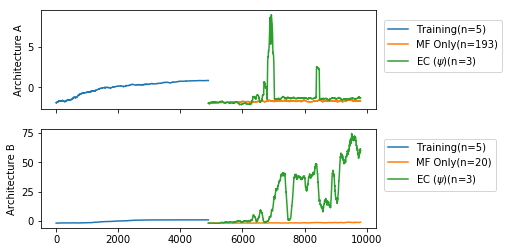

In [19]:
reload(e2)
expts_ = [0,2,5]
arch_A = e2.arch_filter(df,'A', expts=expts_)
arch_B = e2.arch_filter(df,'B', expts=expts_)

smoothing = 100
smoothed_reward_A = smoothed_reward(arch_A, smoothing)
smoothed_reward_B = smoothed_reward(arch_B, smoothing)

fig, ax = plt.subplots(2,1, sharex=True)
for ind, i  in enumerate(smoothed_reward_A):
    if i is not None:
        if ind == 0:
            training_length= len(i)
            ax[0].plot(i, label=experiment_types[ind]+f'(n={arch_A[ind].info.shape[0]})' )
        else:
            ax[0].plot(np.arange(len(i))+training_length, i, label=experiment_types[ind]+f'(n={arch_A[ind].info.shape[0]})' )
for ind, i  in enumerate(smoothed_reward_B):
    if i is not None:
        if ind == 0:
            training_length= len(i[0:5000])
            ax[1].plot(i[0:5000], label=experiment_types[ind]+f'(n={arch_B[ind].info.shape[0]})' )
        else:
            ax[1].plot(np.arange(len(i))+training_length, i, label=experiment_types[ind]+f'(n={arch_B[ind].info.shape[0]})' )            

ax[0].legend(bbox_to_anchor=(1.01,0.95))
ax[1].legend(bbox_to_anchor=(1.01,0.95))
ax[0].set_ylabel('Architecture A')
ax[1].set_ylabel('Architecture B')
plt.show()

In [ ]:
# get list of run ids for each type 
arch_A[2].ids
print(arch_B[2].ids)
list(arch_B[2].ids)[0]

In [ ]:
plot_from_id(list(arch_A[2].ids)[1])

## Observe Testing with MF-EC switching

In [ ]:
alphabet = data_filter(df, alpha=[0.0,0.1,0.2], beta=[1,10,20,30,40])
labels = []

for i in alphabet.ids:
    alpha = alphabet.info.loc[alphabet.info['Run_ID']==i, 'Alpha'].item()
    beta = alphabet.info.loc[alphabet.info['Run_ID']==i, 'Beta'].item()
    labels.append((alpha,beta))

trial_lengths = np.ones(len(labels))*250
trial_lengths[-1] = 50

colours = ['red','blue','green']
for ind, i in enumerate(alphabet.data):
    x= int(labels[ind][0]*10)
    norm_rwd = i['total_reward']/trial_lengths[ind]
    plt.plot(running_mean(norm_rwd, 50), label=labels[ind], color=colours[x])
plt.legend(bbox_to_anchor=(1.05,0.95))

In [ ]:
sig = 0.8
rewards = np.array([np.random.choice([0,1], p=[sig, 1-sig]) for x in range(100)], dtype=float)
rewards[np.where(rewards==0)] = -0.01


ind = 3
id_no = list(alphabet.ids)[ind]
trained_on = alphabet.info.loc[alphabet.info['Run_ID']==id_no, 'Load_Model'].item()[36:-6]
#trained_rw = df.loc[df['Run_ID']==trained_on, ]
alpha = alphabet.info.loc[alphabet.info['Run_ID']==id_no, 'Alpha'].item()
beta = alphabet.info.loc[alphabet.info['Run_ID']==id_no, 'Beta'].item()
print(f'alpha={alpha},beta={beta}')
pp = turds(rewards,alpha=alpha,beta=beta)
plt.title(f'Example Trace alpha={alpha}, beta={beta} (p(reward)={np.round(1-sig,2)})')
plt.plot(rewards,'k|')
plt.plot(pp)
plt.show()
plt.close()
plot_from_id(list(alphabet.ids)[ind], mf=True)


In [ ]:
# load in episodic memory
#run_id = input("Enter Run ID: ")
for xx, run_id in enumerate(alphabet.ids):
    print(run_id, labels[xx])
    print('----------------------')
    agent_dir = f'../data/outputs/gridworld/weights/{run_id}.pt'
    mem_dir = f'../data/outputs/gridworld/episodic_cache/{run_id}_EC.p'
    
    agent = torch.load(agent_dir)
    mem = pickle.load(open(mem_dir, 'rb'))
    
    rwd_loc = df.loc[df['Run_ID'] == run_id, 'Rewards'].item()
    r_x = int(rwd_loc[rwd_loc.index('(')+1 : rwd_loc.index(',')])
    r_y = int(rwd_loc[rwd_loc.index(',')+2 : rwd_loc.index(')')])

    reward_location = (r_x,r_y)

    openfield = gw.GridWorld(rows=20, cols=20, env_type=None, rewards={reward_location:1}, step_penalization=-0.01,
                        actionlist=['Down','Up','Right','Left'], rewarded_action=None)

    #fig = gw.plotWorld(openfield, scale=0.3, four_actions=True)
    obs = openfield.get_sample_obs()
    mf_pol, mf_val = expt.get_snapshot(obs, openfield, agent)
    gp.plot_pref_pol(openfield,mf_pol, threshold=0.1)


    abcd = ec_policies(openfield,mem,trial_timestamp = 0, mem_temp = 0.5)
    gp.plot_pref_pol(openfield, abcd, title='ec_pol_new_rwd',upperbound=2)

In [ ]:
training_A = data_filter(df, expt_type=[0], arch=['A'])
training_B = data_filter(df, expt_type=[0], arch=['B'])

plot_traces([training_A.reward_avg, training_B.reward_avg],sd=[training_A.reward_sd, training_B.reward_sd], labels=['A','B'],smoothing=100)

In [ ]:
testing_B1 = data_filter(df, expt_type=[1])
#testing_B2 = data_filter(df, expt_type=[2])
testing_B3 = data_filter(df, expt_type=[3])
_try = [[testing_B1.reward_avg, testing_B3.reward_avg], [testing_B1.reward_sd, testing_B3.reward_sd]]
plot_traces(_try[0],sds=_try[1],labels=['MF only','EC_phi'],smoothing=30)

In [ ]:
experiments = ['Training', 
               'A-MF Only',
               'A-EC Only ($\psi$)',
               'A-EC Only ($\phi$)',
               'B-MF Only',
               'B-EC Only ($\psi$)', 
               'B-EC Only ($\phi$)'
              ]


## Architecture A -- No SR

In [ ]:
A_runs = df.loc[df['Architecture']=='A']
A_training = A_runs.loc[A_runs['Experiment_Type']==0]

In [ ]:
x=A_runs.iloc[0]


print(type(x['Rewarded_Action']))

## Architecture B - with SR

In [ ]:
B_runs = df.loc[df['Architecture']=='A']
B_training = B_runs.loc[(B_runs['Experiment_Type']==0) &(B_runs['Num_Actions']==4)]

data = []
for id_ in B_training['Run_ID']:
    data.append(pickle.load(open(f'../data/outputs/gridworld/results/{id_}_data.p', 'rb')))

### Training - MF Alone

In [ ]:
smoothing = 30
reward = []
for i in data:
    reward.append(i['total_reward'][0:5000])

average_training_reward = np.mean(np.vstack(reward), axis=0)
sd_training_reward      = np.std(np.vstack(reward), axis=0)

plt.plot(running_mean(average_training_reward, smoothing))
plt.fill_between(np.arange(len(average_training_reward)), average_training_reward-sd_training_reward, average_training_reward+sd_training_reward, alpha=0.2)
plt.title(f'Average Total Trial Reward During Training (n={len(reward)})')
plt.ylim([-2.6, 1.5])
plt.show()

### Testing - MF Alone

In [ ]:
B_MF_testing = B_runs.loc[(B_runs['Experiment_Type'].isin([2])) &(B_runs['Num_Actions']==4)]

MF_data = []
for id_ in B_MF_testing['Run_ID']:
    MF_data.append(pickle.load(open(f'../data/outputs/gridworld/results/{id_}_data.p', 'rb')))

MF_reward = []
for i in MF_data:
    MF_reward.append(i['total_reward'][0:2000])

average_MF_reward = running_mean(np.mean(np.vstack(MF_reward), axis=0), smoothing)
sd_MF_reward      = running_mean(np.std(np.vstack(MF_reward), axis=0),smoothing)

### Testing - EC Alone

In [ ]:
B_EC_testing = B_runs.loc[(B_runs['Experiment_Type'].isin([5])) &(B_runs['Num_Actions']==4)]

EC_data = []
for id_ in B_EC_testing['Run_ID']:
    EC_data.append(pickle.load(open(f'../data/outputs/gridworld/results/{id_}_data.p', 'rb')))
    
EC_reward = []
for i in EC_data:
    EC_reward.append(i['total_reward'][0:2000])

average_EC_reward = running_mean(np.mean(np.vstack(EC_reward), axis=0), smoothing)
sd_EC_reward      = running_mean(np.std(np.vstack(EC_reward), axis=0), smoothing)

In [ ]:
plt.figure()
plt.plot(average_MF_reward, label = f'Frozen Weights (n={len(MF_reward)})')
plt.fill_between(np.arange(len(average_MF_reward)), average_MF_reward-sd_MF_reward, average_MF_reward+sd_MF_reward, alpha=0.2)
plt.plot(average_EC_reward, label = f'Unfrozen Weights (n={len(EC_reward)})')
plt.fill_between(np.arange(len(average_EC_reward)), average_EC_reward-sd_EC_reward, average_EC_reward+sd_EC_reward, alpha=0.2)
#plt.fill_between(np.arange(len(average_reward)), average_reward-sd_reward, average_reward+sd_reward, alpha=0.2)
plt.title(f'Average Total Trial Reward During Testing')

plt.ylim([-2.6, 1.5])
plt.legend(loc = 0)
plt.show()

In [ ]:
plt.figure()
plt.plot(average_MF_reward, label = f'Frozen Weights (n={len(MF_reward)})')
plt.fill_between(np.arange(len(average_MF_reward)), average_MF_reward-sd_MF_reward, average_MF_reward+sd_MF_reward, alpha=0.2)
plt.plot(average_EC_reward, label = f'Unfrozen Weights (n={len(EC_reward)})')
plt.fill_between(np.arange(len(average_EC_reward)), average_EC_reward-sd_EC_reward, average_EC_reward+sd_EC_reward, alpha=0.2)
#plt.fill_between(np.arange(len(average_reward)), average_reward-sd_reward, average_reward+sd_reward, alpha=0.2)
plt.title(f'Average Total Trial Reward During Testing')

plt.ylim([-2.6, 1.5])
plt.legend(loc = 0)
plt.show()

In [ ]:
experiment_number = 2
infos = df.loc[df['Experiment_Type'] == experiment_number, ['Run_ID', 'Memory_Policy_Entropy']].sort_values(by='Memory_Policy_Entropy')[10:13]
print(f'Data for {experiments[experiment_number]}\n',infos)

In [ ]:
ids = infos.values[0:10,0]
entropys = infos.values[0:10,1]

In [ ]:
data = []
for id_num in ids:
    data.append(pickle.load(open(f'../data/outputs/gridworld/{id_num}_data.p', 'rb')))

In [ ]:
#data3 = data
smoothing = 100
for i in range(int(len(data))):
    index = i
    plt.plot(running_mean(data[index]['total_reward'], smoothing), 'r', label = entropys[index])
    plt.plot(running_mean(data3[index]['total_reward'], smoothing),'c', label = entropys[index])
plt.ylim(0, 1.1)
plt.xlim([-50,1850])
plt.legend(loc=0)
plt.show()


In [ ]:
ec_only = data[-1]['total_reward']

In [ ]:
d = []
for i in range(len(data)):
    d.append(data[i]['total_reward'][0:5000])

In [ ]:
mean_MF = np.mean(np.vstack(d),axis=0)

In [ ]:
smoothing = 30
plt.plot(running_mean(mean_MF, smoothing), label = 'MF_only')
plt.plot(running_mean(ec_only, smoothing), label = 'EC_only')
plt.title("Post Training Moved Reward Performance")
plt.legend(loc=0)